# Shampoo Dataset

This dataset appears to have a trend but no seasonal component.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
sns.set_style("darkgrid")

In [2]:
import itertools

import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA

## Load and Prepare Data

In [3]:
df = pd.read_excel("src/shampoo.xls")
df.head()

Date  Sales
0  2000-01  266.0
1  2000-02  145.9
2  2000-03  183.1
3  2000-04  119.3
4  2000-05  180.3

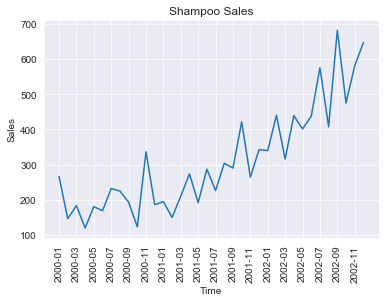

In [4]:
plt.plot(df.Date,df.Sales)
plt.title('Shampoo Sales')
plt.ylabel('Sales')
plt.xlabel('Time')
plt.xticks(rotation=90)
xticks = df.Date.tolist()[::2]
plt.xticks(xticks)
plt.savefig("pic/Shampoo_original.pdf", bbox_inches="tight")
plt.show() 

## Identify and Remove Trend 

First we extract the variables (time and sales) from the dataset. Then we will look at two ways to remove the trend - regression and differencing.

In [5]:
t = np.array(df.index).reshape(-1, 1)
y = df.Sales.values

## Attempt 1 - Linear Regression

To remove the trend we first fit a model and then subtract estimate trend from original data.

### Remove Trend

In [6]:
from sklearn.linear_model import LinearRegression
trend_model = LinearRegression().fit(t, y)
print('model: %.3f t + %.3f' % (trend_model.coef_[0], 
    trend_model.intercept_))
residuals = y - trend_model.predict(t)

model: 12.079 t + 101.216


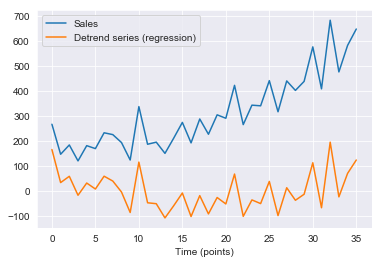

In [7]:
plt.plot(y,  label='Sales')
plt.plot(residuals, '-', label='Detrend series (regression)')
plt.xlabel('Time (points)')
plt.legend()
plt.savefig("pic/Shampoo_detrend_and_original_regression_1.pdf", bbox_inches="tight")
plt.show()

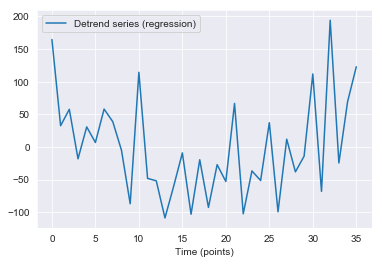

In [8]:
plt.plot(residuals, '-', label='Detrend series (regression)')
plt.xlabel('Time (points)')
plt.legend()
plt.savefig("pic/Shampoo_detrend_regression_1.pdf", bbox_inches="tight")
plt.show()

Notice that our regression fit is not perfect since the residuals appear to start high, go low near the centre, and go high again. Perhaps we should have fitted a polynomial curve?

Also note that when plotting the de-trended series (residuals) with the original series then residuals look OK. This illusion is due to the large verical range so vertical distance are compressed.

We should preform a polynomial regression, but lets continue and see what happens any

### ARMA Model 

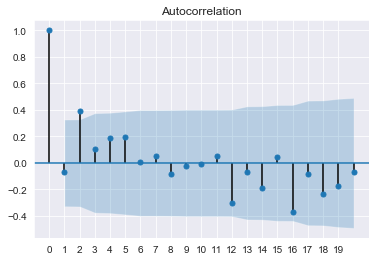

In [9]:
plot_acf(residuals, lags=20)
plt.xticks(range(20))
plt.savefig("pic/Shampoo_regression_1_acf.pdf", bbox_inches="tight")
plt.show() 

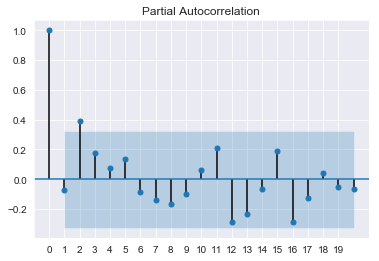

In [10]:
plot_pacf(residuals, lags=20)
plt.xticks(range(20))
plt.savefig("pic/Shampoo_regression_1_pacf.pdf", bbox_inches="tight")
plt.show() 

In [11]:
p = q = range(0, 4)

opt_aic = np.finfo("float").max
opt_pq = None

for pq in itertools.product(p,q):
    try:
        model = ARMA(residuals, order=pq).fit(disp=0)
        print("%s -> %s" % (pq,model.aic))
        if model.aic<opt_aic:
            opt_aic = model.aic
            opt_pq = pq
    except:
        continue

print("Optimal model: ARMA%s with AIC=%.1f" % (opt_pq,opt_aic)) 

(0, 0) -> 418.25346860563087
(0, 1) -> 420.1445970092767
(0, 2) -> 416.36435009358826
(0, 3) -> 418.3525689327014
(1, 0) -> 420.03956659931237
(1, 1) -> 419.8119876209312
(1, 2) -> 409.42744896675634
(2, 0) -> 414.6014084070917
(2, 1) -> 413.7336018208911
(3, 0) -> 414.2269212442845
(3, 1) -> 415.5536041309722
(3, 2) -> 413.07731574544835
Optimal model: ARMA(1, 2) with AIC=409.4


In [12]:
model = ARMA(residuals, order=(1,2)).fit(disp=0)
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   36
Model:                     ARMA(1, 2)   Log Likelihood                -199.714
Method:                       css-mle   S.D. of innovations             56.896
Date:                Sun, 24 Mar 2019   AIC                            409.427
Time:                        14:56:37   BIC                            417.345
Sample:                             0   HQIC                           412.191
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.7610     28.197      0.559      0.580     -39.504      71.026
ar.L1.y        0.7686      0.132      5.826      0.000       0.510       1.027
ma.L1.y       -1.2782      0.139     -9.188      0.0

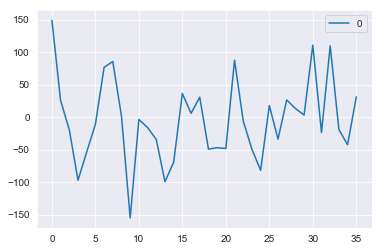

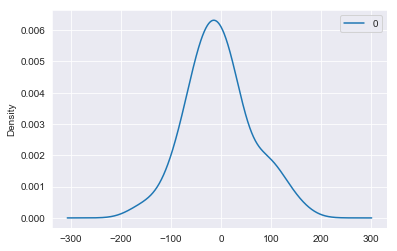

                0
count   36.000000
mean    -4.173472
std     64.343005
min   -155.086536
25%    -47.359822
50%     -8.557897
75%     27.487184
max    149.022740


In [13]:
residuals = pd.DataFrame(model.resid)
residuals.plot()
plt.savefig("pic/Shampoo_regression_1_ARMA_1_2_residuals.pdf", bbox_inches="tight")
plt.show()
residuals.plot(kind='kde')
plt.savefig("pic/Shampoo_regression_1_ARMA_1_2_residuals_kde.pdf", bbox_inches="tight")
plt.show()

print(residuals.describe())

### Summary

 * The final model seems ok, but lets go back and revisit the regression.

## Attempt 2 - Quadratic Regression  

### Remove Trend

In [14]:
from sklearn.preprocessing import PolynomialFeatures
polynomial_features= PolynomialFeatures(degree=2)
t_poly = polynomial_features.fit_transform(t/max(t))
trend_model = LinearRegression().fit(t_poly, y)

residuals = y - trend_model.predict(t_poly)

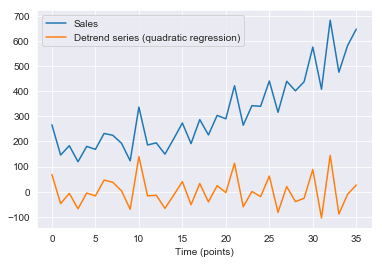

In [15]:
plt.plot(y,  label='Sales')
plt.plot(residuals, '-', label='Detrend series (quadratic regression)')
plt.xlabel('Time (points)')
plt.legend()
plt.savefig("pic/Shampoo_detrend_and_original_regression_2.pdf", bbox_inches="tight")
plt.show()

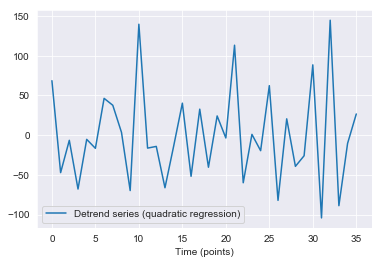

In [16]:
plt.plot(residuals, '-', label='Detrend series (quadratic regression)')
plt.xlabel('Time (points)')
plt.legend()
plt.savefig("pic/Shampoo_detrend_regression_2.pdf", bbox_inches="tight")
plt.show()

### ARMA Model 

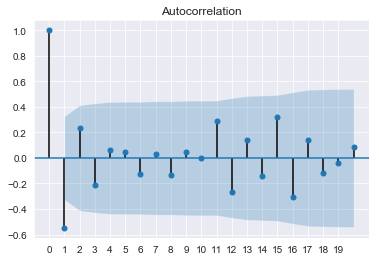

In [17]:
plot_acf(residuals, lags=20)
plt.xticks(range(20))
plt.savefig("pic/Shampoo_regression_2_acf.pdf", bbox_inches="tight")
plt.show() 

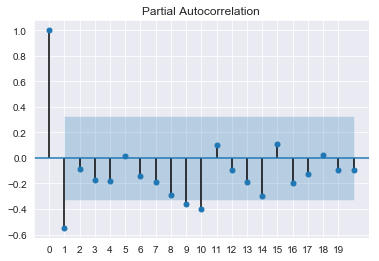

In [18]:
plot_pacf(residuals, lags=20)
plt.xticks(range(20))
plt.savefig("pic/Shampoo_regression_2_pacf.pdf", bbox_inches="tight")
plt.show() 

In [19]:
p = q = range(0, 4)

opt_aic = np.finfo("float").max
opt_pq = None

for pq in itertools.product(p,q):
    try:
        model = ARMA(residuals, order=pq).fit(disp=0)
        print("%s -> %s" % (pq,model.aic))
        if model.aic<opt_aic:
            opt_aic = model.aic
            opt_pq = pq
    except:
        continue

print("Optimal model: ARMA%s with AIC=%.1f" % (opt_pq,opt_aic)) 

(0, 0) -> 401.26202245479436
(0, 1) -> 385.5728256299183
(0, 2) -> 387.1901345734029
(1, 0) -> 390.08471471118935
(1, 1) -> 387.0218300651624
(1, 2) -> 388.77327977255305
(1, 3) -> 388.235803422335
(2, 0) -> 391.8043846579636
(2, 1) -> 387.43359609620035
(2, 2) -> 388.94227226708256
(2, 3) -> nan
(3, 0) -> 392.9633469147946
(3, 1) -> 388.35960849425663
(3, 2) -> 385.5349718046033
(3, 3) -> nan
Optimal model: ARMA(3, 2) with AIC=385.5


In [20]:
model = ARMA(residuals, order=(3,2)).fit(disp=0)
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   36
Model:                     ARMA(3, 2)   Log Likelihood                -185.767
Method:                       css-mle   S.D. of innovations             36.750
Date:                Sun, 24 Mar 2019   AIC                            385.535
Time:                        14:56:40   BIC                            396.620
Sample:                             0   HQIC                           389.404
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2518      0.294      0.855      0.399      -0.325       0.829
ar.L1.y        0.8472      0.162      5.228      0.000       0.530       1.165
ar.L2.y        0.1518      0.203      0.747      0.4

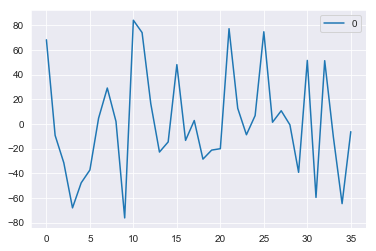

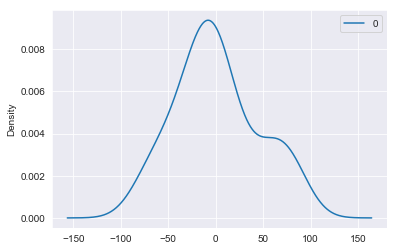

               0
count  36.000000
mean    0.989563
std    43.130724
min   -76.220218
25%   -24.227189
50%    -3.486383
75%    19.667180
max    84.116483


In [21]:
residuals = pd.DataFrame(model.resid)
residuals.plot()
plt.savefig("pic/Shampoo_regression_2_ARMA_3_2_residuals.pdf", bbox_inches="tight")
plt.show()
residuals.plot(kind='kde')
plt.savefig("pic/Shampoo_regression_2_ARMA_3_2_residuals_kde.pdf", bbox_inches="tight")
plt.show()

print(residuals.describe())

### Summary

 * The model fit is better (AIC has reduced from 409 to 385), but the residual kde now has that silly ledge to the right.

## Attempt 3 - Differencing  

### Remove Trend

Differencing just mens we replace the series by differences in adjacent terms.
\\[
    y_k \to y_k - y_{k-1}
\\]
This is much simpler that regression but it does reduce the series length by one.

In [22]:
dy = np.diff(y)

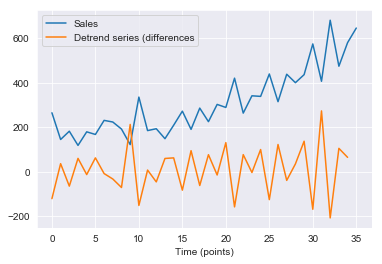

In [23]:
plt.plot(y,  label='Sales')
plt.plot(dy, label='Detrend series (differences')
plt.xlabel('Time (points)')
plt.legend()
plt.savefig("pic/Shampoo_detrend_and_original_difference.pdf", bbox_inches="tight")
plt.show() 

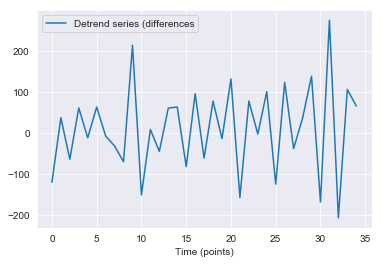

In [24]:
plt.plot(dy, label='Detrend series (differences')
plt.xlabel('Time (points)')
plt.legend()
plt.savefig("pic/Shampoo_detrend_difference.pdf", bbox_inches="tight")
plt.show() 

The residuals here look good, but since we ended up with a quadratic regression fit, we should realy expect to need to use second differences here.  Lets proceed with what we have and see what happens.

### ARMA Model 

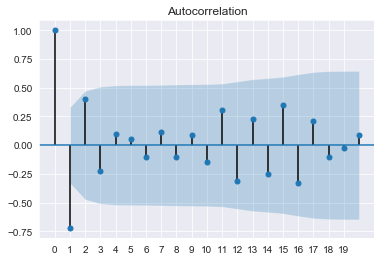

In [25]:
plot_acf(dy, lags=20)
plt.xticks(range(20))
plt.savefig("pic/Shampoo_difference_acf.pdf", bbox_inches="tight")
plt.show() 

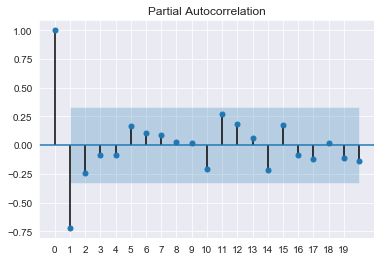

In [26]:
plot_pacf(dy, lags=20)
plt.xticks(range(20))
plt.savefig("pic/Shampoo_difference_pacf.pdf", bbox_inches="tight")
plt.show() 

In [27]:
p = q = range(0, 4)

opt_aic = np.finfo("float").max
opt_pq = None

for pq in itertools.product(p,q):
    try:
        model = ARMA(dy, order=pq).fit(disp=0)
        print("%s -> %s" % (pq,model.aic))
        if model.aic<opt_aic:
            opt_aic = model.aic
            opt_pq = pq
    except:
        continue

print("Optimal model: ARMA%s with AIC=%.1f" % (opt_pq,opt_aic)) 

(0, 0) -> 430.87311187552797
(0, 1) -> 409.0126622411526
(1, 0) -> 406.02228959235015
(1, 1) -> 402.4666524179953
(1, 2) -> 401.5247943798928
(1, 3) -> 403.52417287508956
(2, 0) -> 403.6275641166603
(2, 1) -> 404.28621423318384
(3, 0) -> 404.6924591816878
(3, 1) -> 406.1395443929549
Optimal model: ARMA(1, 2) with AIC=401.5


In [28]:
model = ARMA(dy, order=(1,2)).fit(disp=0)
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   35
Model:                     ARMA(1, 2)   Log Likelihood                -195.762
Method:                       css-mle   S.D. of innovations             59.410
Date:                Sun, 24 Mar 2019   AIC                            401.525
Time:                        14:56:43   BIC                            409.302
Sample:                             0   HQIC                           404.209
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.2822      6.239      1.648      0.109      -1.945      22.510
ar.L1.y        0.1019      0.207      0.492      0.626      -0.304       0.508
ma.L1.y       -1.4369      0.477     -3.013      0.0

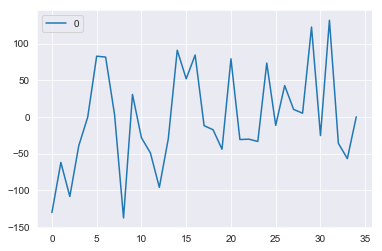

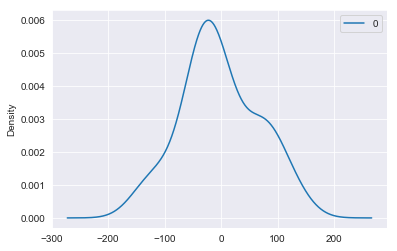

                0
count   35.000000
mean    -2.457241
std     67.641586
min   -137.658963
25%    -37.552553
50%    -11.895093
75%     47.451887
max    131.926331


In [29]:
residuals = pd.DataFrame(model.resid)
residuals.plot()
plt.savefig("pic/Shampoo_dy_ARMA_1_2_residuals.pdf", bbox_inches="tight")
plt.show()
residuals.plot(kind='kde')
plt.savefig("pic/Shampoo_dy_ARMA_1_2_residuals_kde.pdf", bbox_inches="tight")
plt.show()

print(residuals.describe())

### Summary

 * So we have found the same optimal model as before as we found when using linear regression to remove the trend.
 * We should now consider the second difference since we use a quadratic regression, but lets jump to ARIMA models

## Atempt 3 - ARIMA Model

An ARIMA model can perform the differencing step as part of the model. So in this case

__ARMA(1,2)__ applied to __dy__ should gave same result as __ARIMA(1,0,2)__ applied to __dy__, and gave same result as __ARIMA(1,1,2)__ applied to __y__.

In [30]:
model = ARIMA(dy, order=(1,0,2)).fit(disp=0)
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   35
Model:                     ARMA(1, 2)   Log Likelihood                -195.762
Method:                       css-mle   S.D. of innovations             59.410
Date:                Sun, 24 Mar 2019   AIC                            401.525
Time:                        14:56:44   BIC                            409.302
Sample:                             0   HQIC                           404.209
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.2822      6.239      1.648      0.109      -1.945      22.510
ar.L1.y        0.1019      0.207      0.492      0.626      -0.304       0.508
ma.L1.y       -1.4369      0.477     -3.013      0.0

In [31]:
model = ARIMA(y, order=(1,1,2)).fit(disp=0)
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   35
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -195.762
Method:                       css-mle   S.D. of innovations             59.410
Date:                Sun, 24 Mar 2019   AIC                            401.525
Time:                        14:56:44   BIC                            409.302
Sample:                             1   HQIC                           404.209
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.2822      6.239      1.648      0.109      -1.945      22.510
ar.L1.D.y      0.1019      0.207      0.492      0.626      -0.304       0.508
ma.L1.D.y     -1.4369      0.477     -3.013      0.0

In [32]:
p = d = q = range(0, 4)

opt_aic = np.finfo("float").max
opt_pdq = None

for pdq in itertools.product(p,d,q):
    try:
        model = ARIMA(y, order=pdq).fit(disp=0)
        #print("%s -> %s" % (pdq,model.aic))
        if model.aic<opt_aic:
            opt_aic = model.aic
            opt_pdq = pdq
    except:
        continue

print("Optimal model: ARIMA%s with AIC=%.1f" % (opt_pdq,opt_aic)) 

/opt/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimal model: ARIMA(2, 2, 3) with AIC=389.7


In [33]:
model = ARIMA(y, order=(2,2,3)).fit(disp=0)
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   34
Model:                 ARIMA(2, 2, 3)   Log Likelihood                -187.842
Method:                       css-mle   S.D. of innovations             49.755
Date:                Sun, 24 Mar 2019   AIC                            389.684
Time:                        14:56:47   BIC                            400.368
Sample:                             2   HQIC                           393.327
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9216      0.101      9.091      0.000       0.723       1.120
ar.L1.D2.y    -1.4817      0.138    -10.704      0.000      -1.753      -1.210
ar.L2.D2.y    -0.5607      0.139     -4.030      0.0

/opt/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


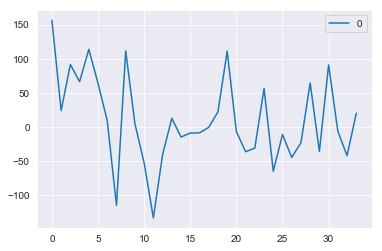

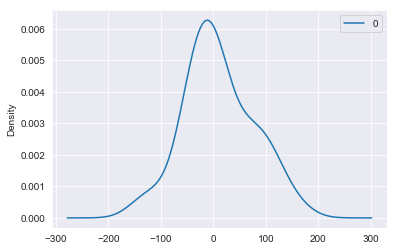

                0
count   34.000000
mean     9.954162
std     65.408579
min   -133.519276
25%    -34.811266
50%     -3.560706
75%     61.996983
max    156.378357


In [34]:
residuals = pd.DataFrame(model.resid)
residuals.plot()
plt.savefig("pic/Shampoo_ARIMA_2_2_3_residuals.pdf", bbox_inches="tight")
plt.show()
residuals.plot(kind='kde')
plt.savefig("pic/Shampoo_ARIMA_2_2_3_residuals_kde.pdf", bbox_inches="tight")
plt.show()
print(residuals.describe())

## Summary 

 * The ARMA parameter search did not find this final model. I should have use the second difference, and not the first differences. 
